# Framework overview

This notebook provides a basic overview of DISCOVER and its functionality. We will introduce the main features of the framework with a basline dataset and how to discover its symbolic expressions with an fundamental workflow.

In [1]:
import warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module='numpy.*')
warnings.filterwarnings("ignore", category=UserWarning, module='tensorflow.*')

from dso.PDE_discover import SymEqOptimizer



/opt/conda/envs/DISCOVER/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/envs/DISCOVER/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/envs/DISCOVER/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/envs/DISCOVER/lib/python3.7/site-packages/tensorflow/python/frame

There are three executation modes in DISCOVER for dealing with different applications. 
* Mode 1 with SymEqOptimizer

The first mode is designed for discoving PDEs from high-quality data. Partial derivatives are evaluated by numerical differentiation on regular grids. DNN can be optionally utilized to smoothe available data and generate meta data to reduce the impact of noise. The introduction of the whole framework can be found in the first paper [PDF](https://journals.aps.org/prresearch/abstract/10.1103/PhysRevResearch.6.013182). GPU is not necessary since the matrix calculation is based on Numpy.

* Mode 2 with Deep_SymEqOptimizer

The second mode originates from a robust verison of DISCOVER, named R_DISCOVER, which is designed to handle sparse and noisy data.  A NN is utilized to fit the system response and evaluate the reward by automatic differentiation. It is trained in a PINN manner when effective physical information are discovered. This mode is more suitable for the high-noisy scenarios. The introduction of the whole framework can be found in the second paper [PDF](https://arxiv.org/ftp/arxiv/papers/2309/2309.07672.pdf). GPU resources are required to acclerate the searching process.

* Mode 3 with DeepLLM_SymEqOptimizer

The third mode is strengthened with Large language models, which tend to generate expressions with physical meanings. It can incoroperate external language-based prior information and acclerate the searching process.

### 1.Define hyperparameters and build model

In [2]:
# load default dataset of Burgers
model = SymEqOptimizer(
    n_samples_per_batch = 500,
    binary_operators = ['add',"mul", "diff","diff2"],
    unary_operators = ['n2'],
    dataset = 'Burgers'
)

-- BUILDING PRIOR START -------------
LengthConstraint: Sequences have minimum length 3.
                  Sequences have maximum length 64.
RepeatConstraint: [add] cannot occur more than 5 times.
TrigConstraint: [diff, diff2] cannot be a descendant of [diff, diff2].
SoftLengthPrior: No description available.
DiffConstraint_left: [x1] cannot be the left child of [diff, diff2].
DiffConstraint_right: [n2, add, mul, diff, diff2, u1] cannot be the right child of [diff, diff2].
DiffConstraint_des: [add] cannot be a descendant of [diff, diff2].
-- BUILDING PRIOR END ---------------



In [3]:
# print defined library
model.info()

Library:  x1,u1,add,mul,diff,diff2,n2


### 2. Model training

In [4]:
# single-iteration training
step_output = model.train_one_step()
print(f"Current best expression is {step_output['expression']} and its reward is {step_output['r']}")

/opt/conda/envs/DISCOVER/lib/python3.7/site-packages/numba/np/ufunc/parallel.py:365: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


Training epoch 1/100, current best R: 0.6273, cost time: 7.01

	** New best
	Reward: 0.6272510841221738
	MSE:0.0022827865681365393
	Invalid: False
	Traversal: mul,mul,diff,u1,x1,x1,n2,u1
	Expression:
0.3821 * mul(mul(diff(u1,x1),x1),n2(u1))
Current best expression is 0.3821 * mul(mul(diff(u1,x1),x1),n2(u1)) and its reward is 0.6272510841221738


In [5]:
# training with defined iterations
# support continual training with model.train()
output = model.train(n_epochs=50)
print(f"Best expression is {output['expression']} and its reward is {output['r']}")

Progress:   8%|████▎                                                 | 4/50 [00:12<02:32,  3.31s/it]

Training epoch 5/50, current best R: 0.6427, cost time: 3.71

	** New best
	Reward: 0.6427472098305989
	MSE:0.0018791723171804446
	Invalid: False
	Traversal: add,diff,n2,u1,x1,mul,n2,diff2,u1,x1,x1
	Expression:
-0.3500 * diff(n2(u1),x1) + 0.0351 * mul(n2(diff2(u1,x1)),x1)


Progress:  18%|█████████▋                                            | 9/50 [00:27<02:00,  2.93s/it]

Training epoch 10/50, current best R: 0.9520, cost time: 2.80

	** New best
	Reward: 0.951975704788587
	MSE:5.914983969248236e-06
	Invalid: False
	Traversal: add,diff2,u1,x1,diff,n2,u1,x1
	Expression:
0.0984 * diff2(u1,x1) + -0.5002 * diff(n2(u1),x1)
Training epoch 10/50, current best R: 0.9520, cost time: 2.80


Progress:  38%|████████████████████▏                                | 19/50 [00:48<01:04,  2.09s/it]

Training epoch 20/50, current best R: 0.9520, cost time: 1.99


Progress:  58%|██████████████████████████████▋                      | 29/50 [01:10<00:46,  2.24s/it]

Training epoch 30/50, current best R: 0.9520, cost time: 2.32


Progress:  78%|█████████████████████████████████████████▎           | 39/50 [01:33<00:24,  2.23s/it]

Training epoch 40/50, current best R: 0.9520, cost time: 2.19


Progress:  98%|███████████████████████████████████████████████████▉ | 49/50 [01:57<00:02,  2.32s/it]

Training epoch 50/50, current best R: 0.9520, cost time: 2.29


Progress: 100%|█████████████████████████████████████████████████████| 50/50 [02:00<00:00,  2.41s/it]

-- Searching End ------------------
Best expression is 0.0984 * diff2(u1,x1) + -0.5002 * diff(n2(u1),x1) and its reward is 0.951975704788587


### 3. Ouput the expression in priorit queue (default: Top 10)

In [6]:
model.print_pq()
#mannually select the finally result


Top 0 result:
	Reward: 0.951975704788587
	MSE:5.914983969248237e-06
	Invalid: False
	Traversal: add,diff,n2,u1,x1,diff2,u1,x1
	Expression:
-0.5002 * diff(n2(u1),x1) + 0.0984 * diff2(u1,x1)

Top 1 result:
	Reward: 0.951975704788587
	MSE:5.914983969248237e-06
	Invalid: False
	Traversal: add,diff,mul,u1,u1,x1,diff2,u1,x1
	Expression:
-0.5002 * diff(mul(u1,u1),x1) + 0.0984 * diff2(u1,x1)

Top 2 result:
	Reward: 0.951975704788587
	MSE:5.914983969248236e-06
	Invalid: False
	Traversal: add,diff2,u1,x1,diff,n2,u1,x1
	Expression:
0.0984 * diff2(u1,x1) + -0.5002 * diff(n2(u1),x1)

Top 3 result:
	Reward: 0.9427449589571766
	MSE:5.704809497430447e-06
	Invalid: False
	Traversal: add,add,u1,diff2,u1,x1,diff,n2,u1,x1
	Expression:
-0.0009 * u1 + 0.0981 * diff2(u1,x1) + -0.4989 * diff(n2(u1),x1)

Top 4 result:
	Reward: 0.9427449589571766
	MSE:5.704809497430447e-06
	Invalid: False
	Traversal: add,add,u1,diff2,u1,x1,diff,mul,u1,u1,x1
	Expression:
-0.0009 * u1 + 0.0981 * diff2(u1,x1) + -0.4989 * diff(mul

### 4. Visulization of results

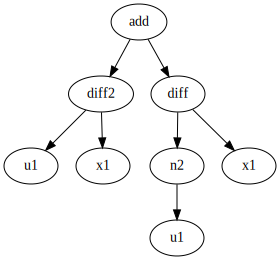

In [7]:
# plot the tree structure of the best expression
graph = model.plot(fig_type ='tree')
graph

2024-09-08 12:47:27,706-matplotlib.font_manager-WARNING-findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
2024-09-08 12:47:27,716-matplotlib.font_manager-WARNING-findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


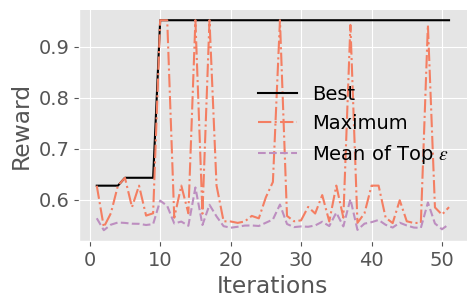

In [8]:
# Plot the evolution process
model.plot(fig_type='evolution')

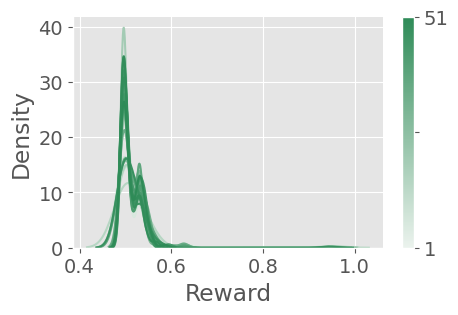

In [9]:
# Plot the density distribution
model.plot(fig_type='density')

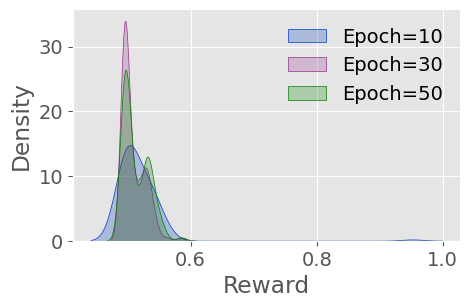

In [10]:
epoches = [10,30,50] # plot the reward distribution of given epoches
model.plot(fig_type='density',epoches=epoches)